In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * (x-c)**2)

In [4]:
class RBFNet(object):
    """Implementation of a Radial Basis Function Network"""
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True, seed = 1234):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.seed = seed
        
        np.random.seed(self.seed)
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
        
    def cluster(self, X):
        # randomly select initial clusters from input data
        clusters = np.random.choice(np.squeeze(X), size=self.k)
        prevClusters = clusters.copy()
        stds = np.zeros(self.k)
        converged = False
        while not converged:
            """
            compute distances for each cluster center to each point 
            where (distances[i, j] represents the distance between the ith point and jth cluster)
            """
            distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))

            # find the cluster that's closest to each point
            closestCluster = np.argmin(distances, axis=1)

            # update clusters by taking the mean of all of the points assigned to that cluster
            for i in range(self.k):
                pointsForCluster = X[closestCluster == i]
                if len(pointsForCluster) > 0:
                    clusters[i] = np.mean(pointsForCluster, axis=0)

            # converge if clusters haven't moved
            converged = np.linalg.norm(clusters - prevClusters) < 1e-6
            prevClusters = clusters.copy()

        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        closestCluster = np.argmin(distances, axis=1)
        clustersWithNoPoints = []

        for i in range(self.k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) < 2:
                # keep track of clusters with no points or 1 point
                clustersWithNoPoints.append(i)
                continue
            else:
                stds[i] = np.std(X[closestCluster == i])

        # if there are clusters with 0 or 1 points, take the mean std of the other clusters
        if len(clustersWithNoPoints) > 0:
            pointsToAverage = []
            for i in range(self.k):
                if i not in clustersWithNoPoints:
                    pointsToAverage.append(X[closestCluster == i])
            pointsToAverage = np.concatenate(pointsToAverage).ravel()
            stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
        
        return clusters, stds
        
        
    def fit(self, X, y):
        if self.inferStds:
            # compute stds from data
            self.centers, self.stds = self.cluster(X)
            
        else:
            # use a fixed std 
            self.centers, _ = self.cluster(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
        # training
        loss_list = []
        for epoch in range(self.epochs):
            loss_list2 = []
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                loss = (y[i] - F).flatten() ** 2
                loss_list2.append(loss[0])
                
                # backward pass
                error = -(y[i] - F).flatten()
                
                # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
                
            loss_mean = sum(loss_list2) / len(loss_list2)
            loss_list.append(loss_mean)
            
            self.centers = (self.centers + self.lr * loss_mean) 
            self.stds = (self.stds + self.lr * loss_mean)
            
            if epoch >= 5 and (loss_list[epoch] > min(loss_list[epoch-5:epoch-1])) :
                return loss_list
        
        return loss_list
    
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

In [6]:
NUM_SAMPLES = 100
np.random.seed(1234)
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X)  + noise


rbfnet_ver1 = RBFNet(lr=1e-2, k=2)
loss_list = rbfnet_ver1.fit(X, y)
y_pred = rbfnet_ver1.predict(X)

In [7]:
loss_list

[0.5315474669252248,
 0.07173595315855627,
 0.04360458789417928,
 0.04085079200082181,
 0.03928020501059211,
 0.0378865870482188,
 0.03667333846236078,
 0.03560431485924855,
 0.034636306165383164,
 0.033737653551133874,
 0.03288822073919735,
 0.032075964517863396,
 0.03129397285671741,
 0.030538431665043803,
 0.029807323581350964,
 0.029099622188773343,
 0.028414805748164563,
 0.027752572529146063,
 0.027112681286736065,
 0.026494868042268322,
 0.025898808291037398,
 0.025324105330419178,
 0.02477029280513035,
 0.024236844269151132,
 0.02372318552556588,
 0.02322870734967925,
 0.022752777331474853,
 0.02229475025208018,
 0.02185397680365894,
 0.021429810680924203,
 0.021021614183967318,
 0.020628762519775298,
 0.020250647000832664,
 0.019886677330359932,
 0.019536283145175627,
 0.019198914964880034,
 0.01887404467342864,
 0.018561165637986547,
 0.01825979255106015,
 0.0179694610655646,
 0.017689727278662692,
 0.017420167108703002,
 0.01716037560012326,
 0.016909966183485642,
 0.0166685

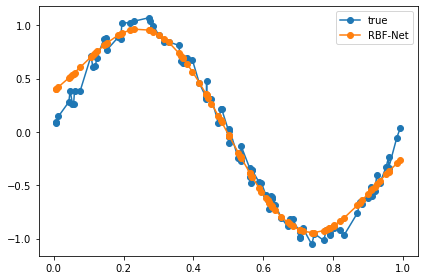

In [8]:
plt.plot(X, y, '-o', label='true')
plt.plot(X, y_pred, '-o', label='RBF-Net')
plt.legend()
plt.tight_layout()
plt.show()